TRABAJO FINAL DE LA MATERIA - MAIE 2024

Alumna: Escalante, Guadalupe Sol

El programa deberá hacer como mínimo:

● descomprimir el archivo ZIP

● realizar un análisis exploratorio de los datos y metadatos de la imagen y mostrar algunos datos de estos

● identificar posibles outlier y enmascararlos a valores nan

● calcular mascara

● recortar bandas

● calcular indice


Se importan las librerías a utilizar

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import copy
from scipy import ndimage
!pip install rasterio
import rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 46.9 MB/s eta 0:00:00


Se monta el directorio en drive en el que trabajaremos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/MAIE/PLANNING/TF')

Mounted at /content/drive


Se descomprimen los archivos

In [ ]:
import zipfile
import os

# primer archivo zip
ruta_zip = '/content/drive/My Drive/MAIE/PLANNING/TF/los_molinos_L8_2023.zip'
directorio_destino_1 = 'zip_descomprimido'
os.makedirs(directorio_destino_1)

with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
     zip_ref.extractall(directorio_destino_1)
     print("Primer archivo ZIP descomprimido")

# segundo archivo zip
ruta_zip_2 = '/content/zip_descomprimido/los_molinos_L8_2023/Los-Molinos_2023-02-07_2_all_bands.zip'
directorio_destino_2 = 'febrero_2023_descomprimido'
os.makedirs(directorio_destino_2)

with zipfile.ZipFile(ruta_zip_2, 'r') as zip_ref:
     zip_ref.extractall(directorio_destino_2)
     print("Segundo archivo ZIP descomprimido")


Primer archivo ZIP descomprimido
Segundo archivo ZIP descomprimido


cargamos imagenes a utilizar y dividimos por 255 para normalizarlas

bandas elegidas:
- para NDVI: 4 y 5  correspondientes al rojo e infrarrojo cercano respectivamente
- Para MNDWI: 3 y 6 correspondientes al verde e infrarrojo medio respectivamente






In [ ]:
ruta_imagenes = '/content/febrero_2023_descomprimido/'
numero = [3,4,5,6]
imagenes = {}

for n in numero:
  ruta_imagen = ruta_imagenes + f'2023-02-07.SR_B{n}.tif'
  nombre_banda = f'B{n}'
  dato = plt.imread(ruta_imagen)/255
  imagenes[nombre_banda] = dato



Representamos cada imagen en escala de grises y agregamos informacion

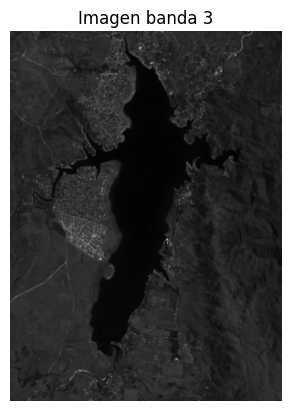

información de la imagen
dimensiones: 406x298
valor mínimo: 29.75
valor máximo: 81.18
SRC: EPSG:32620
formato:GTiff



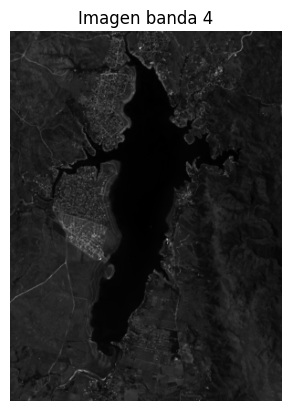

información de la imagen
dimensiones: 406x298
valor mínimo: 29.09
valor máximo: 90.20
SRC: EPSG:32620
formato:GTiff



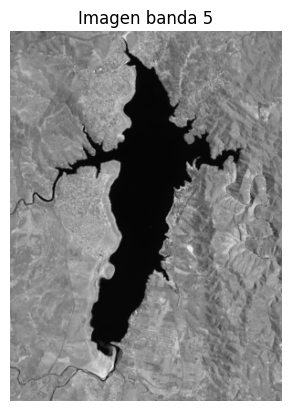

información de la imagen
dimensiones: 406x298
valor mínimo: 28.18
valor máximo: 103.79
SRC: EPSG:32620
formato:GTiff



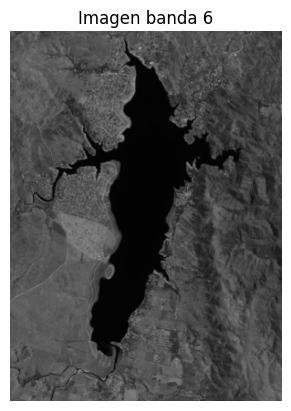

información de la imagen
dimensiones: 406x298
valor mínimo: 28.01
valor máximo: 129.56
SRC: EPSG:32620
formato:GTiff



In [ ]:
numero = [3,4,5,6]

for n in numero:
    #representacion
    nombre_banda = f'B{n}'
    imagen = imagenes[nombre_banda]
    plt.imshow(imagen,cmap='gray')
    plt.axis('off')
    plt.title(f"Imagen banda {n}")
    plt.show()

    #calculo e impresion de dimensiones y valores min/max
    filas, columnas = imagen.shape
    min_val = np.nanmin(imagen)
    max_val = np.nanmax(imagen)
    print("información de la imagen")
    print(f"dimensiones: {filas}x{columnas}")
    print(f"valor mínimo: {min_val:.2f}")
    print(f"valor máximo: {max_val:.2f}")

    #utilizacion de rasterio para imprimir SRC y formato
    ruta_imagen = ruta_imagenes + f'2023-02-07.SR_B{n}.tif'
    with rasterio.open(ruta_imagen) as img:
      print(f"SRC: {img.crs}")
      print(f"formato:{img.driver}\n")


Antes de comenzar a trabajar con las imagenes, corregimos las imagenes utilizando la imagen de calidad para detectar la presencia de nubes.
Info sobre la capa [aquí](https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat8-9-Collection2-Level2-Science-Product-Guide-v5.pdf) (pagina 13)

Definimos la mascara de nubes

In [ ]:
# abrimos la banda de calidad
with rasterio.open(ruta_imagenes + '2023-02-07.QA_PIXEL.tif') as bc:
    bc = bc.read(1)

# definimos los bits de nubes para la mascara (1, 3 y 4). Muesran 1 cuando hay nubes, 0 cuando no hay.
mascara_nubes = (np.bitwise_and(bc, 1 << 1) > 0) | \
                (np.bitwise_and(bc, 1 << 3) > 0) | \
                (np.bitwise_and(bc, 1 << 4) > 0)


Aplicamos la mascara a las imagenes

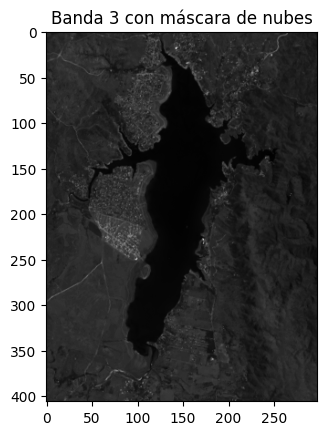

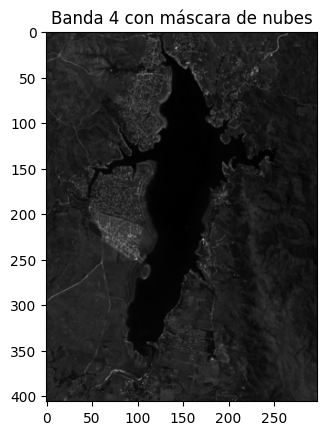

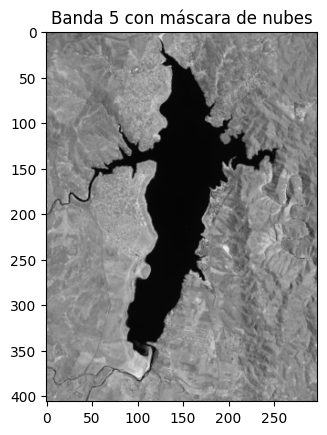

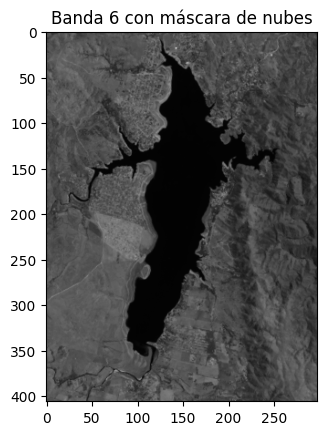

In [ ]:
numero = [3,4,5,6]

for n in numero:
    # Abrir y leer la banda
    nombre_banda = f'B{n}'


    with rasterio.open(ruta_imagenes + f'2023-02-07.SR_B{n}.tif') as img:
        banda = img.read(1)/255

    # Convertir la banda a tipo float para permitir NaN
    banda = banda.astype(float)

    # Aplicar la máscara: establecer NaN donde hay nubes
    banda[mascara_nubes] = np.nan

    # Mostrar y guardar la imagen enmascarada
    plt.imshow(banda, cmap='gray')
    plt.title(f'Banda {n} con máscara de nubes')
    plt.show()

    imagenes[nombre_banda]=banda

Definimos las bandas como variables por practicidad

In [ ]:
B3=imagenes['B3']
B4=imagenes['B4']
B5=imagenes['B5']
B6=imagenes['B6']

Se calcula NDVI. Graficamos (escala entre el minimo y maximo de la imagen)

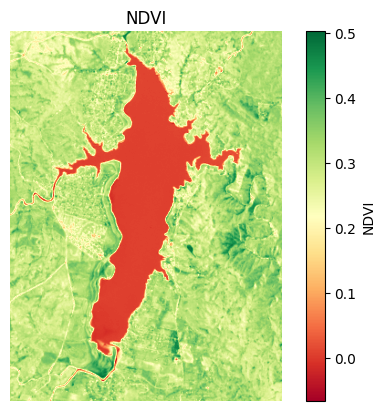

In [ ]:
ndvi = (B5 - B4)/(B5 + B4)

plt.imshow(ndvi, cmap='RdYlGn')
plt.axis('off')
plt.colorbar(label='NDVI')
plt.title('NDVI')
plt.show()


Se calcula MNDWI. Graficamos (escala entre el minimo y maximo de la imagen).

Nota: Los valores positivos del MNDWI generalmente indican la presencia de agua.

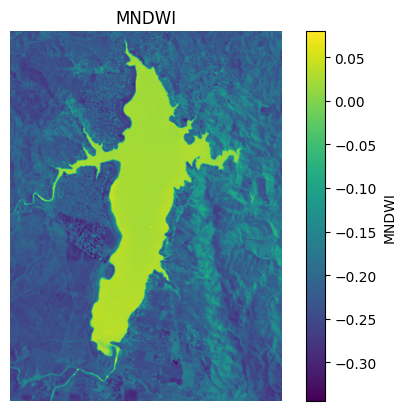

In [ ]:
mndwi = (B3 - B6)/(B3 + B6)

plt.imshow(mndwi)
plt.axis('off')
plt.colorbar(label='MNDWI')
plt.title('MNDWI')
plt.show()

Se hace un histograma de MNDWI

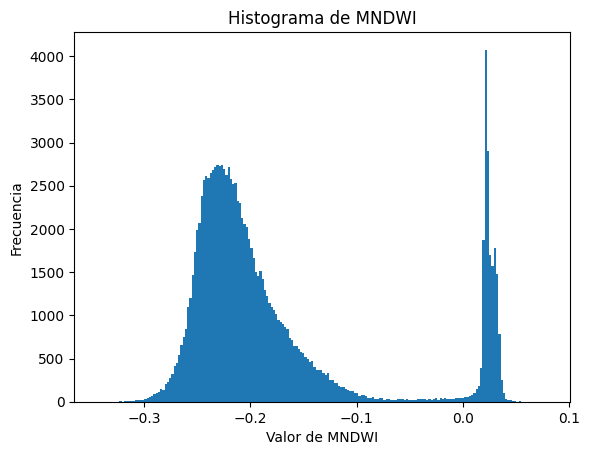

In [ ]:
#aplanamos la imagen para que pueda ser procesada por la función hist().
mndwi_flat = mndwi.flatten()

#graficamos
plt.hist(mndwi_flat, bins=200)
plt.title('Histograma de MNDWI')
plt.xlabel('Valor de MNDWI')
plt.ylabel('Frecuencia')
plt.show()

Se realiza una mascara con los valores mayores a 0 correspondientes a lo que no es agua

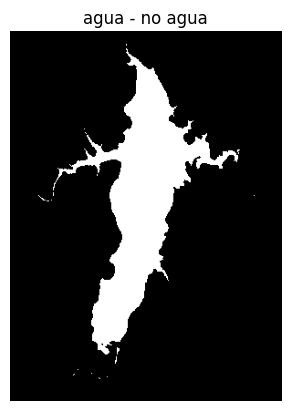

In [ ]:
mascara = mndwi > 0

# Visualizar la máscara de agua
plt.imshow(mascara, cmap='gray')
plt.title('agua - no agua')
plt.axis('off')
plt.show()

Se "corta" la imagen de NDVI. Se le asignan valores NaN a todo lo que no es agua.

In [ ]:
ndvi_cortado = ndvi.copy() #realizamos el proceso sobre una copia
ndvi_cortado[~mascara] = np.nan


Se calcula un histograma de la nueva imagen para ver la distribución de valores de NDVI adentro del lago:

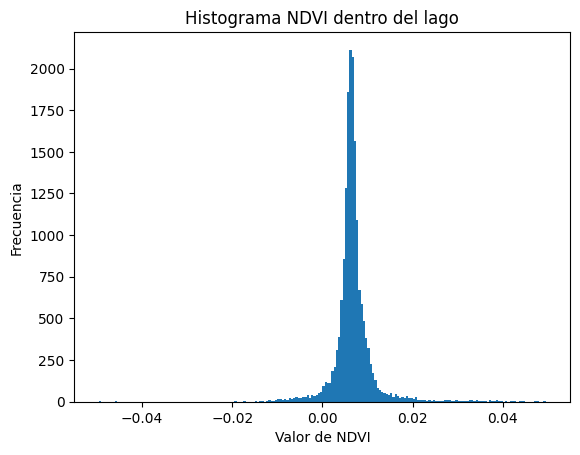

In [ ]:
#aplanamos la imagen para que pueda ser procesada por la función hist().
ndvi_cortado_flat = ndvi_cortado.flatten()

#grafico entre -0.05 y 0.05 para ver con mas detalle
plt.hist(ndvi_cortado_flat, bins=200, range=(-0.05, 0.05))
plt.title('Histograma NDVI dentro del lago')
plt.xlabel('Valor de NDVI')
plt.ylabel('Frecuencia')
plt.show()

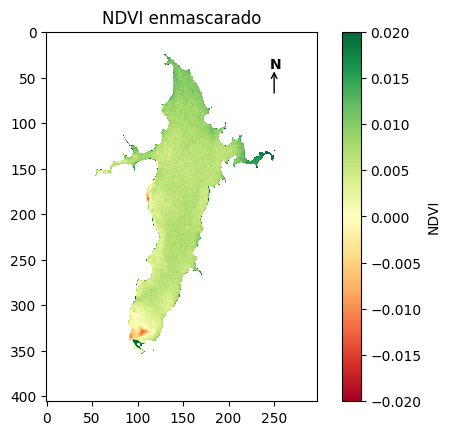

In [ ]:
# Visualizamos la imagen cortada
plt.imshow(ndvi_cortado, cmap='RdYlGn', vmin=-0.02, vmax=0.02)
plt.title('NDVI enmascarado')
plt.colorbar(label='NDVI')

x=250
y=70
plt.annotate('', xy=(x, y - 30), xytext=(x, y), arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.text(245, 40, "N", fontsize=10, color='black', fontweight='bold')

plt.savefig('ndvi_02-2023_L8.tif', dpi=300, bbox_inches='tight')
plt.show()